In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Activation
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import mean_squared_error
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import copy



In [ ]:
battery_capacity = 100
vehicle_capacity = 200
vehicle_velocity = 20
vehicle_energy_decay = 0.02
energy_consumption_per_distance = 0.06
other_resources_consumed_per_distance = 0.2

# Classes

## Customer Class

In [ ]:
class Customer:
    picked_up_flag = False
    id = 0
    demand = 0
    cx = 0
    cy = 0
    tw_start = 0
    tw_end = 0
    service_time = 0

    def __init__(self, index, cx, cy, start_tw, end_tw, quantity, service_time):
        self.id = index
        self.cx = cx
        self.cy = cy
        self.tw_start = start_tw
        self.tw_end = end_tw
        self.demand = quantity
        self.service_time = service_time

    def adapt_demand(self, new_demand):
        self.demand = new_demand

    def adapt_coordinates(self, x, y):
        self.cx = x
        self.cy = y

    def adapt_serive_time(self, new_service_time):
        self.service_time = new_service_time

    def adapt_time_window(self, s_tw, e_tw):
        self.tw_start = s_tw
        self.tw_end = e_tw

    def get_demand(self):
        return self.demand

    def get_coordinates(self):
        return [self.cx, self.cy]

    def get_service_time(self):
        return self.service_time

    def get_time_window(self):
        return [self.tw_start, self.tw_end]

    def picked_up(self):
        self.picked_up_flag = True

    def get_info(self):
      print("picked_up_flag ", self.picked_up_flag,'\n',
            "id ", self.id,'\n',
            "demand ", self.demand,'\n',
            "cx ", self.cx,'\n',
            "cy ", self.cy,'\n',
            "tw_start ", self.tw_start,'\n',
            "tw_end ", self.tw_end,'\n',
            "service_time ", self.service_time,'\n',
            )

## Vehicle_class

In [ ]:
class Vehicle:
    vehicle_id = 0
    cx = 0
    cy = 0
    Max_cap = vehicle_capacity
    Max_battery = battery_capacity
    capacity = 0 ## Q regarding the total number of demands can be held by the vehicle
    current_charge = 0 ## 100 in percent
    departure_nodes = dict() ## Multi depots for both departure and arrival containing their ids and coordinates
    arrival_nodes = dict()
    current_departure_id = 0 ## the current departure node
    current_arrival_id = 0   ## the current arrival node
    max_travel_time = 1000
    current_travel_time = 0
    energy_decay = vehicle_energy_decay
    velocity = vehicle_velocity

    def __init__(self):
        return

    def initiate(self, index, x, y, dep_nodes, arr_nodes, cap_max, max_T, energy_decay, battery_total_capacity, velocity):
        self.vehicle_id = index
        self.cx = x
        self.cy = y
        self.departure_nodes = dep_nodes
        self.arrival_nodes = arr_nodes
        self.capacity = cap_max
        self.max_cap = cap_max
        self.max_travel_time = max_T
        self.current_travel_time = 0
        self.current_charge = battery_total_capacity
        self.max_battery = battery_total_capacity
        self.energy_decay_per_distance = energy_decay
        if len(self.departure_nodes) > 1:
          depot_keys = list(self.departure_nodes.keys()) ## random selection of departure nodes
          rand_index = depot_keys[np.random.randint(0,len(depot_keys)-1)]
          self.current_departure_id = rand_index

          depot_keys = list(self.arrival_nodes.keys()) ## random selection of arrival nodes
          rand_index = depot_keys[np.random.randint(0,len(depot_keys)-1)]
          self.current_arrival_id = rand_index
        else:
          dep_key = list(self.departure_nodes.keys())[0]
          arr_key = list(self.arrival_nodes.keys())[0]
          self.current_departure_id = dep_key
          self.current_arrival_id = arr_key

    def set_current_depot_ids(self, departure, arrival, random = False):

        if len(self.departure_nodes) > 1:
          if random:
            depot_keys = list(self.departure_nodes.keys()) ## random selection of departure nodes
            rand_index = depot_keys[np.random.randint(0,len(depot_keys)-1)]
            self.current_departure_id = rand_index

            depot_keys = list(self.arrival_nodes.keys()) ## random selection of arrival nodes
            rand_index = depot_keys[np.random.randint(0,len(depot_keys)-1)]
            self.current_arrival_id = rand_index
          else:
            self.current_departure_id = departure
            self.current_arrival_id = arrival
        else: ## there is only one option
          dep_key = list(self.departure_nodes.keys())[0]
          arr_key = list(self.arrival_nodes.keys())[0]
          self.current_departure_id = dep_key
          self.current_arrival_id = arr_key


    def get_coordinates(self):
        return [self.cx, self.cy]

    def get_info(self):
          print("id ", self.vehicle_id,'\n',
                "cx ", self.cx, '\n',
                "cy ", self.cy,'\n',
                "Max_cap ", self.Max_cap,'\n',
                "Max_battery ", self.Max_battery,'\n',
                "capacity ", self.capacity,'\n',
                "current_charge ", self.current_charge,'\n',
                "departure_nodes ", self.departure_nodes,'\n',
                "arrival_nodes ", self.arrival_nodes,'\n',
                "current_departure_id ", self.current_departure_id,'\n',
                "current_arrival_id ", self.current_arrival_id,'\n',
                "max_travel_time ", self.max_travel_time,'\n',
                "current_travel_time ", self.current_travel_time,'\n',
                "energy_decay ", self.energy_decay
                )

## Environment Classes

### State and Action Classes

In [ ]:
class StateClass: ## each state indicates the whole current setting of the environment
    time_step = 0
    location_id = 0 ## current client or depot id => the node id on which the vehicle currently is
    vehicle_location = tuple() # for one vehicle
    vehicle_charge = float()
    clients_locations = dict() # the current state of all the clients
    clients_demands = dict() # the current modified state of demands of all the clients

    def get_vector(self): ## get the vector of the vehicle and all the clients for a the current time step
        vectors = dict()
        for client in self.clients_locations.keys(): ## vectors of the current state of each client
            state = np.zeros(shape=(1, 6))[0]
            state[0], state[1] = self.vehicle_location[0], self.vehicle_location[1]
            state[2] = self.vehicle_charge
            state[3], state[4] = self.clients_locations[client][0], self.clients_locations[client][1]
            state[5] = self.clients_demands[client]
            vectors[client] = state
        return vectors

    def client_vector(self, client_id):
            state = np.zeros(shape=(1, 6))[0]
            state[0], state[1] = self.vehicle_location[0], self.vehicle_location[1]
            state[2] = self.vehicle_charge
            state[3], state[4] = self.clients_locations[client_id][0], self.clients_locations[client_id][1]
            state[5] = self.clients_demands[client_id]
            return state

    def vehicle_location_modifier(self, x, y):
        self.vehicle_location = (x,y)

    def demand_modifier(self, client_id, new_demand):
        self.clients_demands[client_id] = new_demand

    def get_info(self):
      print("time_step ", self.time_step,'\n',
            "location_id ", self.location_id,'\n',
            "vehicle_location ", self.vehicle_location,'\n',
            "clients_locations ", self.clients_locations,'\n',
            "clients_demands ", self.clients_demands,'\n',
            )

In [ ]:
class ActionClass:
    next_customer_id = 0
    next_customer_location = tuple()
    vehicle_id = 0
    depot_id = 0
    vehicle_speed = 0
    vehicle_acceleration = 0

    def get_vector(self): ## get the vector of the vehicle and all the clients for a the current time step
        action_vec = np.zeros(shape=(1, 6))[0]
        action_vec[0] = self.next_customer_id
        action_vec[1], action_vec[1] = self.next_customer_location[0], self.next_customer_location[1]
        action_vec[3] = self.vehicle_id
        action_vec[4] = self.depot_id
        action_vec[5] = self.vehicle_speed
        return action_vec

### Environment

In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean

class VRP_environment:
    ## taken states and actions (the experienced settings of the environment)
    states_list = list()
    actions_list = list()
    current_route = list()
    routes = list()

    ## flags
    idle = False ## indicating being
    full_capacity = 0 ## indicating the vehicle's capacity is filled
    done = False ## indicating the stop condition of the environment (all clients have been seen or the time step restriction has passed)

    ## the possible settings
    clients = dict()
    depots = dict()

    ## the current vehicle and state configurations
    vehicle = Vehicle() ## the vehicle associated with this environment and its current configurations
    current_state = StateClass()
    depot_shift_index = len(clients)

    def __init__(self, clients, vehicle, vehicle_id, depots):
        self.clients = clients ## a dictionary of all the clients and their datas
        self.vehicle = vehicle ## variable of the vehicle class containing all the required data about the vehicle
        self.depots = depots

        self.accumulative_cost = 0
        self.accumulative_battery = 0
        self.accumulative_distance = 0

        initial_state = StateClass()
        initial_state.time_step = 0
        initial_state.location_id = self.vehicle.current_departure_id
        initial_state.vehicle_location = (self.vehicle.cx, self.vehicle.cy)
        initial_state.vehicle_charge = self.vehicle.current_charge

        client_keys = list(self.clients.keys())
        for client in client_keys:
            initial_state.clients_locations[client] = self.clients[client].get_coordinates()
            initial_state.clients_demands[client] = self.clients[client].get_demand()

        current_route = list()
        routes = list()
        for client in self.clients:
            self.clients[client].picked_up_flag = False

        self.states_list.append(initial_state)
        self.current_state = initial_state

        self.current_route.append(initial_state.location_id)

    def take_action(self, time_step, next_client_id):
        next_client = self.clients[next_client_id]

       ## defining the action
        action = ActionClass()
        action.next_customer_id = next_client_id
        action.next_customer_location = (next_client.cx, next_client.cy)
        action.vehicle_id = self.vehicle.vehicle_id
        action.vehicle_speed = 0
        action.vehicle_acceleration = 0

        ## taking the action
        next_state = StateClass()
        next_state.time_step = time_step
        next_state.location_id = next_client_id
        next_state.vehicle_location = (next_client.cx, next_client.cy)
        next_state.vehicle_charge = self.vehicle.current_charge

        next_state.client_id = next_client_id
        next_state.clients_locations = self.current_state.clients_locations
        next_state.clients_demands = self.current_state.clients_demands

        self.vehicle.cx = next_client.cx
        self.vehicle.cy = next_client.cy
        self.vehicle.current_charge = next_state.vehicle_charge

        new_demand = next_state.clients_demands[next_client_id] - self.vehicle.capacity
        self.vehicle.capacity = self.vehicle.capacity - next_state.clients_demands[next_client_id]
        if new_demand <=0:
            new_demand = 0
        next_state.clients_demands[next_client_id] = new_demand

        self.clients[next_client_id].picked_up()
        self.states_list.append(next_state)

        if self.vehicle.capacity <= 0:
            self.full_capacity = True

        return action, next_state

    def return_to_depot(self, timestep):
        depot_id = self.vehicle.current_arrival_id

        ## defining the depot state
        depot_state = StateClass()
        depot_state.time_step = timestep
        depot_state.client_id = depot_id
        depot_state.vehicle_location = (float(self.depots[depot_id]['dep_x']), float(self.depots[depot_id]['dep_y']))
        depot_state.vehicle_charge = self.vehicle.current_charge
        depot_state.clients_locations = self.current_state.clients_locations ## the locations and demands do not change
        depot_state.clients_demands = self.current_state.clients_demands

        ## defining the action for the depot
        action = ActionClass()
        action.next_customer_id = depot_id
        action.next_customer_location = (self.depots[depot_id]['dep_x'], self.depots[depot_id]['dep_y'])
        action.vehicle_id = self.vehicle.vehicle_id
        action.vehicle_speed = 0
        action.vehicle_acceleration = 0

        self.states_list.append(depot_state)

        self.vehicle.current_charge = self.vehicle.Max_battery
        self.vehicle.cx = self.depots[depot_id]['dep_x']
        self.vehicle.cy = self.depots[depot_id]['dep_y']
        self.vehicle.capacity = self.vehicle.max_cap
        self.vehicle.current_charge = self.vehicle.max_battery

        self.full_capacity = False

        return action, depot_state


    def remaining_state_check(self):
      for client in self.clients.keys():
        if not self.clients[client].picked_up_flag:
          return True
      return False

    def terminal_check(self):
      # print("all clients seen results", not self.remaining_state_check(), self.vehicle.vehicle_id)
      return (not self.remaining_state_check())


    ## Revise: the first reward function; use uncertainty instead of constant
    def reward_function_1(self):
        # total_reward = -cost_a_t - (distance_at * (1- battery_level_st1)) - waiting_time_st1
        total_reward = 0
        cost_total = 0

        ## Cost
        state_location = self.states_list[-2].vehicle_location
        next_location = self.states_list[-1].vehicle_location
        dist = euclidean(state_location, next_location)
        cost_total += dist/self.vehicle.velocity
        cost_total += dist*energy_consumption_per_distance
        cost_total += dist*other_resources_consumed_per_distance

        self.accumulative_cost += cost_total
        self.accumulative_distance += dist

        ## Battery
        battery_consumed_at_action_t = dist*energy_consumption_per_distance
        battery = (self.states_list[-2].vehicle_charge - battery_consumed_at_action_t)*(1-self.vehicle.energy_decay)
        self.vehicle.current_charge = self.states_list[-1].vehicle_charge = battery

        total_reward -= self.accumulative_cost
        total_reward -= self.accumulative_distance
        client_id = self.states_list[-1].client_id
        if client_id in self.clients.keys():
          waiting_time = self.clients[client_id].service_time
        else:
          waiting_time = 0

        total_reward = total_reward - float(waiting_time)

        return total_reward

    ## The second reward function for the DQN method
    def reward_function_2(self, action, tw_violated, reached_depot):
        reward = 0
        pickedup_users = list()
        notpicked_up = list()
        for c in self.clients.keys():
            if self.clients[c].picked_up_flag == 1:
                pickedup_users.append(c)
            elif self.clients[c].picked_up_flag == 0:
                notpicked_up.append(c)

        ##determine the time from the starting depot to the ending
        depot_start = self.vehicle.departure_nodes[self.vehicle.current_departure_id]
        depot_end = self.vehicle.departure_nodes[self.vehicle.current_arrival_id]
        subtract = (float(depot_start['dep_x'])-float(depot_end['dep_x']), float(depot_start['dep_y'])-float(depot_end['dep_y']))
        t_p1p2 = np.linalg.norm(subtract)/self.vehicle.velocity


        if self.idle or tw_violated:
            # print("first_option")
            reward = -1000

        elif reached_depot and len(notpicked_up)==0 :
            # print("second_option")
            reward = +1000

        elif reached_depot and len(notpicked_up)>0:
            # print("third_option")
            demands = 0
            for client in pickedup_users:
                demands += self.clients[client].demand * 10
            reward = demands - 10*t_p1p2

        else:
            # print("forth_option")
            demands = 0
            for client in pickedup_users:
                demands += self.clients[client].demand**2
            reward = - 10*t_p1p2 - demands

        return reward

# Depot vector generator

In [ ]:
def depot_vectors(depots, vehicle, depot_id):
      state = np.zeros(shape=(1, 6))[0]
      state[0], state[1] = vehicle.cx, vehicle.cy
      state[2] = vehicle.current_charge
      state[3], state[4] = depots[depot_id]['dep_x'], depots[depot_id]['dep_y']
      state[5] = 0
      return state


# Plotting the map

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

def vrp_plot(environment, route):

  fig, ax = plt.subplots()
  ax.set_aspect("equal")

  plt.rcParams["figure.figsize"] = [10, 10]
  plt.rcParams["figure.autolayout"] = False

  x_coordinates = dict()
  y_coordinates = dict()
  for item in environment.clients:
    x,y = environment.clients[item].get_coordinates()
    x_coordinates[item] = x/10
    y_coordinates[item] = y/10

  depots_x = dict()
  depots_y = dict()
  for depot in environment.depots:  ## ToDo: modify this to the depot
      depots_x[depot] = float(environment.depots[depot]['dep_x'])/10
      depots_y[depot] = float(environment.depots[depot]['dep_y'])/10

  plt.scatter(list(depots_x.values()), list(depots_y.values()), color = 'black')
  plt.plot(list(x_coordinates.values()), list(y_coordinates.values()), 'r*')

  index = 0
  for xy in zip(list(depots_x.values()), list(depots_y.values())):
    plt.annotate('D'+str(index), xy=xy)
    index += 1

  index = 0
  for xy in zip(list(x_coordinates.values()), list(y_coordinates.values())):
    # plt.annotate('C'+str(index)+' (%.2f, %.2f)' % xy, xy=xy)
    plt.annotate('C'+str(index), xy=xy)
    index += 1


  for i in range(0,len(route)-1):
    if i == 0:
      ar = FancyArrowPatch ((depots_x[route[i]],depots_y[route[i]]),
                          (x_coordinates[route[i+1]],y_coordinates[route[i+1]]),
                              arrowstyle=']->', mutation_scale=5, color="blue")
    elif 1 <= i< (len(route)-2):
      ar = FancyArrowPatch ((x_coordinates[route[i]],y_coordinates[route[i]]),
                          (x_coordinates[route[i+1]],y_coordinates[route[i+1]]),
                              arrowstyle=']->', mutation_scale=5, color="blue")
    elif i == (len(route)-2):
      ar = FancyArrowPatch ((x_coordinates[route[i]],y_coordinates[route[i]]),
                          (depots_x[route[i+1]],depots_y[route[i+1]]),
                              arrowstyle=']->', mutation_scale=5, color="blue")

    ax.add_patch(ar)

  plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

def Mvrp_plot(clients, depots, episode_routes, episode_num, vehicle_num):

  for episode in range(0, episode_num): ## each key is tuple of episode and vehicle
        fig, ax = plt.subplots()
        ax.set_aspect("equal")

        plt.rcParams["figure.figsize"] = [10, 10]
        plt.rcParams["figure.autolayout"] = False

        x_coordinates = dict()
        y_coordinates = dict()
        for item in clients:
          x,y = clients[item].get_coordinates()
          x_coordinates[item] = x/10
          y_coordinates[item] = y/10

        depots_x = dict()
        depots_y = dict()
        for depot in depots:  ## ToDo: modify this to the depot
            depots_x[depot] = float(depots[depot]['dep_x'])/10
            depots_y[depot] = float(depots[depot]['dep_y'])/10

        plt.scatter(list(depots_x.values()), list(depots_y.values()), color = 'black')
        plt.plot(list(x_coordinates.values()), list(y_coordinates.values()), 'r*')

        index = 0
        for xy in zip(list(depots_x.values()), list(depots_y.values())):
          plt.annotate('D'+str(index), xy=xy)
          index += 1

        index = 0
        for xy in zip(list(x_coordinates.values()), list(y_coordinates.values())):
          # plt.annotate('C'+str(index)+' (%.2f, %.2f)' % xy, xy=xy)
          plt.annotate('C'+str(index), xy=xy)
          index += 1


        for vehicle in range(vehicle_num):
          r = np.round(np.random.rand(),1)
          g = np.round(np.random.rand(),1)
          b = np.round(np.random.rand(),1)

          color = (r, g, b)
          routes = episode_routes[(episode,vehicle)]
          print(routes)
          for route in routes:
            if len(route) >2:
              for i in range(0,len(route)-1):
                if i == 0:
                  ar = FancyArrowPatch ((depots_x[route[i]],depots_y[route[i]]),
                                      (x_coordinates[route[i+1]],y_coordinates[route[i+1]]),
                                          arrowstyle=']->', mutation_scale=5, color=color)
                elif 1 <= i< (len(route)-2):
                  ar = FancyArrowPatch ((x_coordinates[route[i]],y_coordinates[route[i]]),
                                      (x_coordinates[route[i+1]],y_coordinates[route[i+1]]),
                                          arrowstyle=']->', mutation_scale=5, color=color)
                elif i == (len(route)-2):
                  ar = FancyArrowPatch ((x_coordinates[route[i]],y_coordinates[route[i]]),
                                      (depots_x[route[i+1]],depots_y[route[i+1]]),
                                          arrowstyle=']->', mutation_scale=5, color=color)

                ax.add_patch(ar)

        plt.show()


# DQN

### 2

In [ ]:
import torch.optim as optim
import torch as T
import torch.nn as nn
import torch.nn.functional as F
class DeepQNetwork(nn.Module):
  def __init__(self, input_dims, n_actions, fc1_dims, fc2_dims, lr):
    super(DeepQNetwork, self).__init__()
    self.input_dims = input_dims
    self.n_actions = n_actions
    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.lr = lr
    self.gamma = 0.99
    self.exploration_proba = 1.0
    self.exploration_proba_decay = 0.005
    self.batch_size = 32

    self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
    self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
    self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
    self.optimizer = optim.Adam(self.parameters(), lr = self.lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)


  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    actions = self.fc3(x)
    return actions


  def update_exploration_probability(self):
    self.exploration_proba = self.exploration_proba * np.exp(-self.exploration_proba_decay)
    # print(self.exploration_proba)


class Agent():
  def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
               max_mem_size = 10000, eps_end = 0.01, eps_dec = 5e-4):
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_min = eps_end
    self.eps_dec = eps_dec
    self.lr = lr
    self.actions_space = [i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    self.mem_cntr = 0

    self.Q_eval = DeepQNetwork(input_dims, n_actions, fc1_dims=256, fc2_dims=256, lr=self.lr)
    self.target_Q = copy.deepcopy(self.Q_eval)

    self.state_memory = np.zeros((self.mem_size, input_dims), dtype=np.float32)
    self.new_state_memory = np.zeros((self.mem_size, input_dims), dtype=np.float32)
    self.action_memory = np.zeros(self.mem_size, dtype=np.float32)
    self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
    self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

  def store_transition(self, state, action, reward, new_state, done):
    index= self.mem_cntr % self.mem_size
    self.state_memory[index] = state
    self.new_state_memory[index] = new_state
    self.reward_memory[index] = reward
    self.action_memory[index] = action
    self.terminal_memory[index] = done
    self.mem_cntr += 1

  def save_models(self):
    print("..... Saving Models .....")
    # T.save(self.Q_eval, "/content/drive/MyDrive/Projects/Dr_Shahbazian/MDVRP/Proposed Methods/Solomon_dataset/saved_models/RF1/Q_network_DQN.h5")
    # T.save(self.target_Q, "/content/drive/MyDrive/Projects/Dr_Shahbazian/MDVRP/Proposed Methods/Solomon_dataset/saved_models/RF1/Target_network_DQN.h5")

  def choose_action(self, observation):
    observation = observation.astype(np.float32)
    state = T.tensor(observation).to(self.Q_eval.device)
    actions = self.Q_eval.forward(state)
    # action = T.argmax(actions).item()
    return actions

  def learn(self):
    if self.mem_cntr < self.batch_size:
      return

    self.Q_eval.optimizer.zero_grad()
    max_mem = min(self.mem_cntr, self.mem_size)
    batch = np.random.choice(max_mem, self.batch_size, replace=False)

    batch_index = np.arange(self.batch_size, dtype=np.int32)

    state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
    new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
    reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
    terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

    action_batch = self.action_memory[batch]

    q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
    q_next = self.target_Q.forward(new_state_batch)
    q_next[terminal_batch] = 0.0

    q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

    loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    self.epsilon = self.epsilon-self.eps_dec if self.epsilon>self.eps_min else self.eps_min
    return loss

# Reading the Dataset

## Functions

In [ ]:
def client_data_structure(nodes_data):
    customers = dict()
    customer_id = 0
    for row in range(len(nodes_data)):
        id, cx, cy = nodes_data['CUST_NO.'][row], float(nodes_data['XCOORD.'][row]), float(nodes_data['YCOORD.'][row])
        tw_start, tw_end = nodes_data['READY_TIME'][row], nodes_data['DUE_DATE'][row]
        quantity = float(nodes_data['DEMAND'][row])
        service_time =  float(nodes_data['SERVICE_TIME'][row])
        customers[customer_id] = Customer(customer_id, float(cx), float(cy), float(tw_start), float(tw_end),
                                          float(quantity), float(service_time))
        customer_id += 1
    return customers

In [ ]:
def vehicle_depot_data_structure(nodes_data, depot_shift_index):

    vehicles = dict()
    depots = dict()

    vehicle_id = 0
    depot_id = depot_shift_index

    for row in range(len(nodes_data)):
        ind, cx, cy = nodes_data['CUST_NO.'][row], float(nodes_data['XCOORD.'][row]), float(nodes_data['YCOORD.'][row])
        # cx /= 100
        # cy/= 100

        capacity = vehicle_capacity
        max_travel_time = nodes_data['DUE_DATE'][row]

        depots[depot_id] = {'dep_x':cx, 'dep_y':cy}

        vehicles[vehicle_id] = Vehicle()
        vehicles[vehicle_id].initiate(vehicle_id, float(cx), float(cy), depots, depots,
                                    float(capacity), float(max_travel_time), vehicle_energy_decay, battery_capacity, vehicle_velocity)
        vehicle_id += 1
        depot_id += 1

    return vehicles, depots

In [ ]:
def creat_data_model(train_df, valid_df, test_df):
  depot_num_train = 1
  train_depots = train_df[0:depot_num_train]
  train_data = train_df[depot_num_train:]
  train_data = train_data.reset_index(drop=True)

  depot_num_valid = 1
  valid_depots = valid_df[0:depot_num_valid]
  valid_data = valid_df[depot_num_valid:]
  valid_data = valid_data.reset_index(drop=True)

  depot_num_test = 1
  test_depots = test_df[0:depot_num_test]
  test_data = test_df[depot_num_test:]
  test_data = test_data.reset_index(drop=True)

  train_clients_data = client_data_structure(train_data)
  valid_clients_data = client_data_structure(valid_data)
  test_clients_data = client_data_structure(test_data)

  train_depot_shift = len(train_clients_data)
  valid_depot_shift = len(valid_clients_data)
  test_depot_shift = len(test_clients_data)

  train_vehicles, train_depots = vehicle_depot_data_structure(train_depots, train_depot_shift)
  valid_vehicles, valid_depots = vehicle_depot_data_structure(valid_depots, valid_depot_shift)
  test_vehicles, test_depots = vehicle_depot_data_structure(test_depots, test_depot_shift)

  train = {'clients': train_clients_data,
              'depots': train_depots,
              'vehicles': train_vehicles}

  valid = {'clients': valid_clients_data,
                'depots': valid_depots,
                'vehicles': valid_vehicles}

  test = {'clients': test_clients_data,
                'depots': test_depots,
                'vehicles': test_vehicles}

  return train, valid, test

In [ ]:
def create_data_ind(dataframe, depot_num):
  depots = dataframe[0:depot_num]
  data = dataframe[depot_num:]
  data = data.reset_index(drop=True)

  clients_data = client_data_structure(data)

  depot_shift = len(clients_data)

  data_vehicles, data_depots = vehicle_depot_data_structure(depots, depot_shift)

  data = {'clients': clients_data,
              'depots': data_depots,
              'vehicles': data_vehicles}

  return data

# MVRP

In [ ]:
dataset_num = 1
dataset = "RC"

## Data Preparation

In [ ]:
if dataset_num <=9:
  if dataset == "C":
    data_path = "/content/drive/MyDrive/Projects/Dr_Shahbazian/MDVRP/Datasets/Solomon/C1/c10"+str(dataset_num)+".txt"
  elif dataset == "RC":
    data_path = "/content/drive/MyDrive/Projects/Dr_Shahbazian/MDVRP/Datasets/Solomon/RC1/rc10"+str(dataset_num)+".txt"
  elif dataset == "R":
    data_path = "/content/drive/MyDrive/Projects/Dr_Shahbazian/MDVRP/Datasets/Solomon/R1/r10"+str(dataset_num)+".txt"
else:
  if dataset == "C":
    data_path = "/content/drive/MyDrive/Projects/Dr_Shahbazian/MDVRP/Datasets/Solomon/C1/c1"+str(dataset_num)+".txt"
  elif dataset == "RC":
    data_path = "/content/drive/MyDrive/Projects/Dr_Shahbazian/MDVRP/Datasets/Solomon/RC1/rc1"+str(dataset_num)+".txt"
  elif dataset == "R":
    data_path = "/content/drive/MyDrive/Projects/Dr_Shahbazian/MDVRP/Datasets/Solomon/R1/r1"+str(dataset_num)+".txt"



# vehicle_numbers = {
#     1: {25:4 ,50:8 ,100:15},
#     2: {25:3 ,50:7 ,100:14},
#     3: {25:3 ,50:6 ,100:11},
#     4: {25:3 ,50:5 ,100:10},
#     5: {25:4 ,50:8 ,100:15},
#     6: {25:3 ,50:6 ,100:11},
#     7: {25:3 ,50:6 ,100:12},
#     8: {25:3 ,50:6 ,100:11}
#     }

# vehicle_num = vehicle_numbers[dataset_num]

In [ ]:
data_df = pd.read_csv(data_path, delim_whitespace=True)

depot_num = 1
depots = data_df[0:depot_num]
vehicle_nodes = depots
data_df = data_df[depot_num:]

train_df = depots
valid_df = depots
test_df = depots

train_test_ratio = 0.25
train_valid_ratio = 0.5
train_test_length = int(len(data_df)*train_test_ratio)
train_valid_length = int(len(data_df)*train_valid_ratio)
print(train_valid_length)
print(train_test_length)

train_nodes = data_df[0:]
train_df = pd.concat([train_df,train_nodes], ignore_index=True)

valid_nodes = data_df[train_valid_length:train_valid_length+train_test_length]
valid_df = pd.concat([valid_df,valid_nodes], ignore_index=True)

test_nodes = data_df[train_valid_length+train_test_length:]
test_df = pd.concat([test_df,test_nodes], ignore_index=True)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print("train",len(train_df))
print("valid",len(valid_df))
print("test",len(test_df))

train_data = create_data_ind(train_df, depot_num)
valid_data = create_data_ind(valid_df, depot_num)
test_data = create_data_ind(test_df, depot_num)

50
25
train 101
valid 26
test 26


## Algorithms

## Multi Vehicle

### Adding additional depots and vehicles

In [ ]:
def adding_depot_vehicles(data, v_num):
  ## modifying the problem to multi-depot and multi_vehicle
  depot = {'dep_x':'30.0', 'dep_y': '60.0'}
  data['depots'][max(data['depots'].keys())+1] = depot

  id = max(data['vehicles'].keys())
  added_vehicles_data = {}
  for i in range(v_num):
    id += 1
    added_vehicles_data[i] = Vehicle()
    added_vehicles_data[i].initiate(id+1, 30.0, 40.0, data['depots'], data['depots'], vehicle_capacity, 1000, vehicle_energy_decay, battery_capacity, vehicle_velocity)
    data['vehicles'][id] = added_vehicles_data[i]


  return data

### Validation Multi Vehicle

In [ ]:
def validate_multi_vehicle(valid_df, agent, v_num, vehicle_id, reward_fn):
  # print("Validation ...", vehicle_id)

  valid_data = create_data_ind(valid_df, 1)
  valid_data = adding_depot_vehicles(valid_data, v_num-1)
  clients = valid_data['clients']
  vehicles = valid_data['vehicles']
  depots = valid_data['depots']

  env = VRP_environment(clients, vehicles[vehicle_id], vehicle_id, depots)
  env.routes = []
  env.current_route = [env.vehicle.current_departure_id]

  state_dim = 6
  action_dim = len(clients)+len(depots)

  env.done = False
  time_step_acumulative_reward = 0
  rewards = []
  time_step = 0
  total_steps = 0
  rept = 0
  while not env.done and rept < 5000:
      remaining_demands = set(env.current_state.clients_demands.values())
      if 0 in remaining_demands:
          remaining_demands.remove(0)
      if env.full_capacity or env.vehicle.capacity < min(remaining_demands): ##ToDO: recheck for the random or deliberate selection of the depot to go
          selected_action, next_state = env.return_to_depot(time_step)
          if reward_fn == 1:
            reward = env.reward_function_1()
          elif reward_fn == 2:
            reward = env.reward_function_2(selected_action, False, True)
          next_client_id = env.vehicle.current_arrival_id
          next_state_vector = depot_vectors(depots, env.vehicle, env.vehicle.current_arrival_id)
          action_id = env.vehicle.current_arrival_id
          # print("capacity is full", "reward = ", reward, next_client_id, next_state_vector)
          env.current_route.append(next_client_id)
          env.routes.append(env.current_route)
          env.current_route = []

      else:
        current_state_id = env.current_state.location_id
        if current_state_id in depots.keys(): ## the current state is the depot
            current_state_vector = depot_vectors(depots, env.vehicle, current_state_id)
        elif current_state_id in clients.keys(): ## the current state is one of the clients
            current_state_vector = env.current_state.client_vector(current_state_id)

        current_state_vector = current_state_vector.reshape(1,6)

        env.idle = False
        reward = 0
        if np.random.uniform(0,1) < agent.Q_eval.exploration_proba: ## the client is being chosen at random by the vehicle based on the epsilon-greedy
        # if np.random.uniform(0,1) < 0.2:
            # print("Random selection of the actions")
            next_client_id= np.random.randint(0,len(env.clients.keys())) ## ToDo: recheck whether the depot should be an option
            next_client = env.clients[next_client_id]

            repeat = 0
            while next_client.picked_up_flag and env.remaining_state_check() and repeat <= len(env.clients):
              next_client_id= np.random.randint(len(env.clients.keys()))
              next_client = env.clients[next_client_id]
              repeat += 1

        else: ## the client is being chosen deliberately based on the highest Q value given by the network
          # print("Select the best option possible")
          actions = agent.choose_action(current_state_vector)
          q_values = actions.cpu().detach().numpy()[0]
          q_values = q_values[0:len(clients)]
          next_client_id = np.argmax(q_values)
          next_client = env.clients[next_client_id]

          repeat = 0
          while next_client.picked_up_flag and env.remaining_state_check() and repeat <= len(env.clients):
              q_values[next_client_id] = -np.inf
              next_client_id = np.argmax(q_values)
              next_client = env.clients[next_client_id]
              repeat += 1
          next_client = env.clients[next_client_id]

        # print("Capacity =>", env.vehicle.capacity , next_client.demand)
        if env.vehicle.capacity < next_client.demand or next_client.picked_up_flag == True:
          rept += 1
          continue

        if next_client.tw_start <=time_step<= next_client.tw_end: ## checking the time window perservation constraint
          selected_action, next_state = env.take_action(time_step, next_client_id)
          if reward_fn == 1:
              reward = env.reward_function_1()
          elif reward_fn == 2:
              reward = env.reward_function_2(selected_action, False, False)

        elif time_step < next_client.tw_start: ## the vehicle needs to wait for the time step in which the client will come
            env.idle = True
            time_difference = next_client.tw_start - time_step
            time_step = next_client.tw_start ##shifting the time step to avoid wasting time
            selected_action, next_state = env.take_action(time_step, next_client_id)
            if reward_fn == 1:
                reward = env.reward_function_1()
            elif reward_fn == 2:
                reward = env.reward_function_2(selected_action, True, False)
            reward = reward *time_difference

        elif time_step > next_client.tw_end:
            ## the action is taken and the client is also picked up but the vehicle receives a penalty
            selected_action, next_state = env.take_action(time_step, next_client_id)
            if reward_fn == 1:
                reward = env.reward_function_1()
            elif reward_fn == 2:
                reward = env.reward_function_2(selected_action, True, False)

        next_state_vector = next_state.client_vector(next_client_id)
        action_id = selected_action.next_customer_id

      agent.store_transition(current_state_vector, int(action_id), reward, np.array([next_state_vector]), env.done)

      time_step_acumulative_reward += reward
      rewards.append(reward)

      env.current_state = next_state
      env.current_route.append(next_client_id)

      env.done = env.terminal_check()
      if env.done:
        # print("done is ", env.done)
        agent.Q_eval.update_exploration_probability()

        if env.current_route[-1] not in depots.keys():
          selected_action, next_state = env.return_to_depot(time_step)
          if reward_fn == 1:
            reward = env.reward_function_1()
          elif reward_fn == 2:
            reward = env.reward_function_2(selected_action, False, True)
          next_client_id = env.vehicle.current_arrival_id
          next_state_vector = depot_vectors(depots, env.vehicle, env.vehicle.current_arrival_id)
          action_id = env.vehicle.current_arrival_id
          env.current_route.append(next_client_id)

        env.routes.append(env.current_route)
        env.current_route = []

      time_step += 1
      total_steps += 1
      # print("===========================================\n")

  valid_loss = agent.learn()
  # print("Validation mean reward", np.mean(rewards))
  return np.mean(rewards), env.routes, agent, valid_loss

### Train Multi Vehicle

In [ ]:
def train_multi_vehicle(n_episodes, n_time_steps, train_df, valid_df, n_vehicles,
                              Q_update_frequency = 10, Target_update_freq = 100,
                              reward_fn = 1):
  train_data = create_data_ind(train_df, 1)
  train_data = adding_depot_vehicles(train_data, n_vehicles-1)
  clients = train_data['clients']
  vehicles = train_data['vehicles']
  depots = train_data['depots']

  state_dim = 6
  action_dim = len(clients)+len(depots)

  envs = dict() ## one environment for each vehicle
  total_vehicle_routes = dict() ## total passed routes for each vehicle based on each episode
  total_episode_route = dict() ## total passed routes for all the episodes (inside of it is the above dictionary)
  vehicle_step_acumulative_reward = dict() ## acumulative rewards for each vehicle at the end of each episode
  Agents = dict()

  mean_valid = {}
  valid_routes = {}
  best_rewards = {}

  loss_values = dict()
  valid_loss = dict()

  for vehicle in vehicles.keys():
      Agents[vehicle] = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions = action_dim,
              eps_end=0.01, input_dims=state_dim, lr=0.003)
      total_vehicle_routes[vehicle] = dict()
      best_rewards[vehicle] = -np.inf
      loss_values[vehicle] = []
      valid_loss[vehicle] = []

  for episode in range(n_episodes):
      # print("\n episode = ", episode)
      train_data = create_data_ind(train_df, 1)
      train_data = adding_depot_vehicles(train_data, v_num=n_vehicles-1)
      clients = train_data['clients']
      vehicles = train_data['vehicles']
      depots = train_data['depots']

      global_time_step = 0

      for vehicle_id in vehicles.keys():
          vehicle_step_acumulative_reward[(episode, vehicle_id)] = 0
          envs[vehicle_id] = VRP_environment(clients, vehicles[vehicle_id], vehicle_id, depots)
          envs[vehicle_id].routes = []
          envs[vehicle_id].current_route = [envs[vehicle_id].vehicle.current_departure_id]
          envs[vehicle_id].done = False
          envs[vehicle_id].full_capacity = False
          envs[vehicle_id].vehicle.current_travel_time = 0

      while global_time_step <= n_time_steps:
        for v_id in range(n_vehicles):
          if global_time_step < envs[v_id].vehicle.current_travel_time and envs[v_id].idle:
                # print("The vehicle is idle")
                if reward_fn == 1:
                  reward = envs[v_id].reward_function_1()
                elif reward_fn == 2:
                  reward = -1000
                vehicle_step_acumulative_reward[(episode, v_id)] += reward

          ## if vehicle.done == True => the vehicle has finished its process and it should go one with other vehicles
          elif global_time_step >= envs[v_id].vehicle.current_travel_time and not envs[v_id].done:
              remaining_demands = set(envs[v_id].current_state.clients_demands.values())
              if 0 in remaining_demands:
                  remaining_demands.remove(0)
              min_demands = 0
              if len(remaining_demands):
                  min_demands = min(remaining_demands)

              if envs[v_id].full_capacity or envs[v_id].vehicle.capacity < min_demands: ##ToDO: recheck for the random or deliberate selection of the depot to go
                  selected_action, next_state = envs[v_id].return_to_depot(envs[v_id].vehicle.current_travel_time)
                  if reward_fn == 1:
                    reward = envs[v_id].reward_function_1()
                  elif reward_fn == 2:
                    reward = envs[v_id].reward_function_2(selected_action, False, True)
                  next_client_id = envs[v_id].vehicle.current_arrival_id
                  next_state_vector = depot_vectors(envs[v_id].depots, envs[v_id].vehicle, envs[v_id].vehicle.current_arrival_id)
                  action_id = envs[v_id].vehicle.current_arrival_id
                  # print("capacity is full for the vehicle with id number = ", v_id, "reward = ", reward, next_client_id)

                  envs[v_id].current_route.append(next_client_id)
                  envs[v_id].routes.append(envs[v_id].current_route)
                  envs[v_id].current_route = []

              elif envs[v_id].remaining_state_check():
                  current_state_id = envs[v_id].current_state.location_id
                  if current_state_id in envs[v_id].depots.keys(): ## the current state is the depot
                      current_state_vector = depot_vectors(envs[v_id].depots, envs[v_id].vehicle, current_state_id)
                  elif current_state_id in envs[v_id].clients.keys(): ## the current state is one of the clients
                      current_state_vector = envs[v_id].current_state.client_vector(current_state_id)
                  current_state_vector = current_state_vector.reshape(1,6)

                  envs[v_id].idle = False
                  reward = 0
                  ## the client is being chosen at random by the vehicle based on the epsilon-greedy
                  if np.random.uniform(0,1) < Agents[v_id].Q_eval.exploration_proba:
                      # print("==> Random selection of the actions")
                      ## ToDo: recheck whether the depot should be an option
                      repeat = 0
                      while True:
                        next_client_id= np.random.randint(0,len(envs[v_id].clients.keys()))
                        next_client = envs[v_id].clients[next_client_id]
                        if next_client.picked_up_flag == False or repeat > len(envs[v_id].clients):
                          break
                        repeat += 1
                      # print("next_client_id",next_client_id)

                  else: ## the client is being chosen deliberately based on the highest Q value given by the network
                      # print("==> Select the best option possible")
                      actions = Agents[v_id].choose_action(current_state_vector)
                      q_values = actions.cpu().detach().numpy()[0]
                      q_values = q_values[0:len(envs[v_id].clients)]
                      next_client_id = np.argmax(q_values)
                      next_client = envs[v_id].clients[next_client_id]

                      repeat = 0
                      while True:
                        next_client_id = np.argmax(q_values)
                        next_client = envs[v_id].clients[next_client_id]
                        if next_client.picked_up_flag == False or repeat > len(envs[v_id].clients):
                          break
                        q_values[next_client_id] = -np.inf
                        repeat += 1
                      # print("next_client_id",next_client_id)

                  if envs[v_id].vehicle.capacity < next_client.demand or next_client.picked_up_flag == True:
                    continue

                  # print("time window =>",next_client.tw_start, envs[v_id].vehicle.current_travel_time, next_client.tw_end)
                  if next_client.tw_start <= envs[v_id].vehicle.current_travel_time <= next_client.tw_end: ## checking the time window perservation constraint
                    selected_action, next_state = envs[v_id].take_action(envs[v_id].vehicle.current_travel_time, next_client_id)
                    if reward_fn == 1:
                      reward = envs[v_id].reward_function_1()
                    elif reward_fn == 2:
                      reward = envs[v_id].reward_function_2(selected_action, False, False)
                    envs[v_id].clients[next_state.location_id].picked_up()

                  elif envs[v_id].vehicle.current_travel_time < next_client.tw_start: ## the vehicle needs to wait for the time step in which the client will come
                      envs[v_id].idle = True
                      time_difference = next_client.tw_start - envs[v_id].vehicle.current_travel_time
                      envs[v_id].vehicle.current_travel_time = next_client.tw_start ##shifting the time step to avoid wasting time
                      selected_action, next_state = envs[v_id].take_action(envs[v_id].vehicle.current_travel_time, next_client_id)
                      if reward_fn == 1:
                        reward = envs[v_id].reward_function_1()
                        battery_decay = time_difference*envs[v_id].vehicle.energy_decay
                        envs[v_id].vehicle.current_charge -=  battery_decay
                      elif reward_fn == 2:
                        reward = envs[v_id].reward_function_2(selected_action, True, False)
                      envs[v_id].clients[next_state.location_id].picked_up()

                  elif envs[v_id].vehicle.current_travel_time > next_client.tw_end:
                      ## the action is taken, the client is picked up and the vehicle receives a penalty
                      selected_action, next_state = envs[v_id].take_action(envs[v_id].vehicle.current_travel_time, next_client_id)
                      if reward_fn == 1:
                        reward = envs[v_id].reward_function_1()
                      elif reward_fn == 2:
                        reward = envs[v_id].reward_function_2(selected_action, True, False)
                      envs[v_id].clients[next_state.location_id].picked_up()

                  next_state_vector = next_state.client_vector(next_client_id)
                  action_id = selected_action.next_customer_id

              Agents[v_id].store_transition(current_state_vector, action_id, reward, next_state_vector, envs[v_id].done)

              vehicle_step_acumulative_reward[(episode, v_id)] += reward

              envs[v_id].current_state = next_state
              envs[v_id].current_route.append(next_client_id)
              # print(envs[v_id].current_route, envs[v_id].routes)
              # envs[v_id].current_state.get_info()

              ## updating the whole environment for all the vehicles to know what clients have been picked up by others
              for item in envs.keys():
                envs[item].current_state.clients_demands = envs[v_id].current_state.clients_demands
                envs[item].clients = envs[v_id].clients

              if global_time_step % Q_net_update_freq == 0 and global_time_step > 0:
                # print("Training_phase\n")
                loss_values[v_id].append(Agents[v_id].learn())

              if global_time_step % update_target_freq == 0 and global_time_step > 0:
                Agents[v_id].target_Q = copy.deepcopy(Agents[v_id].Q_eval)

              envs[v_id].done = not envs[v_id].remaining_state_check() ## if the terminal condition has been seen
              if envs[v_id].done:
                # print("done is ", envs[v_id].done)
                Agents[v_id].Q_eval.update_exploration_probability()

                if envs[v_id].current_route[-1] not in list(depots.keys()):
                  selected_action, next_state = envs[v_id].return_to_depot(envs[v_id].vehicle.current_travel_time)
                  if reward_fn == 1:
                    reward = envs[v_id].reward_function_1()
                  elif reward_fn == 2:
                    reward = envs[v_id].reward_function_2(selected_action, False, True)
                  next_client_id = envs[v_id].vehicle.current_arrival_id
                  next_state_vector = depot_vectors(envs[v_id].depots, envs[v_id].vehicle, envs[v_id].vehicle.current_arrival_id)
                  action_id = envs[v_id].vehicle.current_arrival_id
                  # print("The process is done for the vehicle = ", v_id)

                  envs[v_id].current_route.append(next_client_id)
                  envs[v_id].routes.append(envs[v_id].current_route)
                  envs[v_id].current_route = []
                else:
                  envs[v_id].routes.append(envs[v_id].current_route)
                  envs[v_id].current_route = []

                continue ## go on with the other vehicle

              envs[v_id].vehicle.current_travel_time += 1
              # print("================ vehicle", v_id,"================")
        global_time_step += 1

      # if episode % 100 == 0:
      print("======= episode", episode," finished ======= ")
      for v_index in envs.keys():
        total_episode_route[(episode, v_index)] = envs[v_index].routes

      for v_id in range(n_vehicles):
        mean_valid[(episode, v_id)], valid_routes[(episode, v_id)], Agents[v_id], loss = validate_multi_vehicle(valid_df, Agents[v_id], n_vehicles,v_id, reward_fn)
        valid_loss[v_id].append(loss)
        if mean_valid[(episode, v_id)] > best_rewards[v_id]:
          best_rewards[v_id] = mean_valid[(episode, v_id)]

  train_results = dict()
  train_results["routes"] = total_episode_route
  train_results["ac_rewards"] = vehicle_step_acumulative_reward
  train_results["loss"] = loss_values

  valid_results = dict()
  valid_results['mean_valid'] = mean_valid
  valid_results['valid_routes'] = valid_routes
  valid_results['best_rewards'] = best_rewards
  valid_results['loss'] = valid_loss

  networks = {}
  networks["agent"] = Agents
  return train_results, valid_results, networks
  # return train_results, networks

### Main Function

In [ ]:
import time
start_time = time.time()

n_episodes = 400
n_time_steps = 1000
# n_vehicles = vehicle_num[100]
n_vehicles = 3
Q_net_update_freq = 10
update_target_freq = 100
reward_fn_number = 2

train_results, valid_results, networks = train_multi_vehicle (n_episodes, n_time_steps,
                              train_df, valid_df, n_vehicles,
                              Q_update_frequency = 10, Target_update_freq = 100,
                              reward_fn = reward_fn_number)

finish_time = time.time()

In [ ]:
print(f"start time => {start_time}")
print(f"finsih time => {finish_time}")

print(f"taken time for {n_episodes} episodes is {(finish_time-start_time)/60} mins")

start time => 1688304978.4766197
finsih time => 1688305203.9791162
taken time for 400 episodes is 3.7583749413490297 mins


In [ ]:
train_results["loss"].keys()

dict_keys([0, 1, 2])

In [ ]:
# train_loss_value = []

# for item in train_results["loss"][0]:
#   if item:
#     train_loss_value.append(item.item())

# plt.plot(train_loss_value ,label= "Vehicle 0")
# plt.legend()

In [ ]:
# valid_loss_value = []

# for item in valid_results["loss"][0]:
#   if item:
#     valid_loss_value.append(item.item())

# plt.plot(valid_loss_value ,label= "Vehicle 0")
# plt.legend()

### Test

In [ ]:
# n_samples = 10
# test_mean_reward = dict()
# test_tours = dict()
# for rep in range(n_samples):
#   print(rep)
#   for v_id in range(n_vehicles):
#     test_mean_reward[v_id] = []
#     test_tours[v_id] = []

#   for v_id in range(n_vehicles):
#     mean_valid, valid_tours, _ = validate_multi_vehicle(test_df, networks['agent'][v_id], n_vehicles,v_id, reward_fn_number)
#     test_mean_reward[v_id].append(mean_valid)
#     test_tours[v_id].append(valid_tours)
#     print(f"==============Vehicle {v_id}===============\n")

# Evaluations 25 50 100

### Function

In [ ]:
def evaluation_multi_vehicle(n_episodes, eval_df, networks, n_vehicles, reward_fn):

  eval_data = create_data_ind(eval_df, 1)
  eval_data = adding_depot_vehicles(eval_data, n_vehicles-1)
  clients = eval_data['clients']
  vehicles = eval_data['vehicles']
  depots = eval_data['depots']

  state_dim = 6
  action_dim = len(clients)+len(depots)

  envs = dict() ## one environment for each vehicle
  total_vehicle_routes = dict() ## total passed routes for each vehicle based on each episode
  total_episode_route = dict() ## total passed routes for all the episodes (inside of it is the above dictionary)
  vehicle_step_acumulative_reward = dict() ## acumulative rewards for each vehicle at the end of each episode
  Agents = dict()

  mean_valid = {}
  valid_routes = {}
  best_rewards = {}

  for vehicle in vehicles.keys():
      Agents[vehicle] = networks['agent'][vehicle]
      total_vehicle_routes[vehicle] = dict()
      best_rewards[vehicle] = -np.inf

  for episode in range(n_episodes):
      # print("\n episode = ", episode)
      eval_data = create_data_ind(eval_df, 1)
      eval_data = adding_depot_vehicles(eval_data, n_vehicles-1)
      clients = eval_data['clients']
      vehicles = eval_data['vehicles']
      depots = eval_data['depots']

      global_time_step = 0

      for vehicle_id in vehicles.keys():
          vehicle_step_acumulative_reward[(episode, vehicle_id)] = 0
          envs[vehicle_id] = VRP_environment(clients, vehicles[vehicle_id], vehicle_id, depots)
          envs[vehicle_id].routes = []
          envs[vehicle_id].current_route = [envs[vehicle_id].vehicle.current_departure_id]
          envs[vehicle_id].done = False
          envs[vehicle_id].full_capacity = False
          envs[vehicle_id].vehicle.current_travel_time = 0

      while global_time_step <= n_time_steps:
        for v_id in range(n_vehicles):
          if global_time_step < envs[v_id].vehicle.current_travel_time and envs[v_id].idle:
                # print("The vehicle is idle")
                if reward_fn == 1:
                  reward = envs[v_id].reward_function_1()
                elif reward_fn == 2:
                  reward = -1000
                vehicle_step_acumulative_reward[(episode, v_id)] += reward

          ## if vehicle.done == True => the vehicle has finished its process and it should go one with other vehicles
          elif global_time_step >= envs[v_id].vehicle.current_travel_time and not envs[v_id].done:
              remaining_demands = set(envs[v_id].current_state.clients_demands.values())
              if 0 in remaining_demands:
                  remaining_demands.remove(0)
              min_demands = 0
              if len(remaining_demands):
                  min_demands = min(remaining_demands)

              if envs[v_id].full_capacity or envs[v_id].vehicle.capacity < min_demands: ##ToDO: recheck for the random or deliberate selection of the depot to go
                  selected_action, next_state = envs[v_id].return_to_depot(envs[v_id].vehicle.current_travel_time)
                  if reward_fn == 1:
                    reward = envs[v_id].reward_function_1()
                  elif reward_fn == 2:
                    reward = envs[v_id].reward_function_2(selected_action, False, True)
                  next_client_id = envs[v_id].vehicle.current_arrival_id
                  next_state_vector = depot_vectors(envs[v_id].depots, envs[v_id].vehicle, envs[v_id].vehicle.current_arrival_id)
                  action_id = envs[v_id].vehicle.current_arrival_id
                  # print("capacity is full for the vehicle with id number = ", v_id, "reward = ", reward, next_client_id)

                  envs[v_id].current_route.append(next_client_id)
                  envs[v_id].routes.append(envs[v_id].current_route)
                  envs[v_id].current_route = []

              elif envs[v_id].remaining_state_check():
                  current_state_id = envs[v_id].current_state.location_id
                  if current_state_id in envs[v_id].depots.keys(): ## the current state is the depot
                      current_state_vector = depot_vectors(envs[v_id].depots, envs[v_id].vehicle, current_state_id)
                  elif current_state_id in envs[v_id].clients.keys(): ## the current state is one of the clients
                      current_state_vector = envs[v_id].current_state.client_vector(current_state_id)
                  current_state_vector = current_state_vector.reshape(1,6)

                  envs[v_id].idle = False
                  reward = 0
                  ## the client is being chosen at random by the vehicle based on the epsilon-greedy
                  if np.random.uniform(0,1) < Agents[v_id].Q_eval.exploration_proba:
                      # print("==> Random selection of the actions")
                      ## ToDo: recheck whether the depot should be an option
                      repeat = 0
                      while True:
                        next_client_id= np.random.randint(0,len(envs[v_id].clients.keys()))
                        next_client = envs[v_id].clients[next_client_id]
                        if next_client.picked_up_flag == False or repeat > len(envs[v_id].clients):
                          break
                        repeat += 1
                      # print("next_client_id",next_client_id)

                  else: ## the client is being chosen deliberately based on the highest Q value given by the network
                      # print("==> Select the best option possible")
                      actions = Agents[v_id].choose_action(current_state_vector)
                      q_values = actions.cpu().detach().numpy()[0]
                      q_values = q_values[0:len(envs[v_id].clients)]
                      next_client_id = np.argmax(q_values)
                      next_client = envs[v_id].clients[next_client_id]

                      repeat = 0
                      while True:
                        next_client_id = np.argmax(q_values)
                        next_client = envs[v_id].clients[next_client_id]
                        if next_client.picked_up_flag == False or repeat > len(envs[v_id].clients):
                          break
                        q_values[next_client_id] = -np.inf
                        repeat += 1
                      # print("next_client_id",next_client_id)

                  if envs[v_id].vehicle.capacity < next_client.demand or next_client.picked_up_flag == True:
                    continue

                  # print("time window =>",next_client.tw_start, envs[v_id].vehicle.current_travel_time, next_client.tw_end)
                  if next_client.tw_start <= envs[v_id].vehicle.current_travel_time <= next_client.tw_end: ## checking the time window perservation constraint
                    selected_action, next_state = envs[v_id].take_action(envs[v_id].vehicle.current_travel_time, next_client_id)
                    if reward_fn == 1:
                      reward = envs[v_id].reward_function_1()
                    elif reward_fn == 2:
                      reward = envs[v_id].reward_function_2(selected_action, False, False)
                    envs[v_id].clients[next_state.location_id].picked_up()

                  elif envs[v_id].vehicle.current_travel_time < next_client.tw_start: ## the vehicle needs to wait for the time step in which the client will come
                      envs[v_id].idle = True
                      time_difference = next_client.tw_start - envs[v_id].vehicle.current_travel_time
                      envs[v_id].vehicle.current_travel_time = next_client.tw_start ##shifting the time step to avoid wasting time
                      selected_action, next_state = envs[v_id].take_action(envs[v_id].vehicle.current_travel_time, next_client_id)
                      if reward_fn == 1:
                        reward = envs[v_id].reward_function_1()
                        battery_decay = time_difference*envs[v_id].vehicle.energy_decay
                        envs[v_id].vehicle.current_charge -=  battery_decay
                      elif reward_fn == 2:
                        reward = envs[v_id].reward_function_2(selected_action, True, False)
                      envs[v_id].clients[next_state.location_id].picked_up()

                  elif envs[v_id].vehicle.current_travel_time > next_client.tw_end:
                      ## the action is taken, the client is picked up and the vehicle receives a penalty
                      selected_action, next_state = envs[v_id].take_action(envs[v_id].vehicle.current_travel_time, next_client_id)
                      if reward_fn == 1:
                        reward = envs[v_id].reward_function_1()
                      elif reward_fn == 2:
                        reward = envs[v_id].reward_function_2(selected_action, True, False)
                      envs[v_id].clients[next_state.location_id].picked_up()

                  next_state_vector = next_state.client_vector(next_client_id)
                  action_id = selected_action.next_customer_id

              Agents[v_id].store_transition(current_state_vector, action_id, reward, next_state_vector, envs[v_id].done)

              vehicle_step_acumulative_reward[(episode, v_id)] += reward

              envs[v_id].current_state = next_state
              envs[v_id].current_route.append(next_client_id)
              # print(envs[v_id].current_route, envs[v_id].routes)
              # envs[v_id].current_state.get_info()

              ## updating the whole environment for all the vehicles to know what clients have been picked up by others
              for item in envs.keys():
                envs[item].current_state.clients_demands = envs[v_id].current_state.clients_demands
                envs[item].clients = envs[v_id].clients

              envs[v_id].done = not envs[v_id].remaining_state_check() ## if the terminal condition has been seen
              if envs[v_id].done:
                # print("done is ", envs[v_id].done)
                Agents[v_id].Q_eval.update_exploration_probability()

                if envs[v_id].current_route[-1] not in list(depots.keys()):
                  selected_action, next_state = envs[v_id].return_to_depot(envs[v_id].vehicle.current_travel_time)
                  if reward_fn == 1:
                    reward = envs[v_id].reward_function_1()
                  elif reward_fn == 2:
                    reward = envs[v_id].reward_function_2(selected_action, False, True)
                  next_client_id = envs[v_id].vehicle.current_arrival_id
                  next_state_vector = depot_vectors(envs[v_id].depots, envs[v_id].vehicle, envs[v_id].vehicle.current_arrival_id)
                  action_id = envs[v_id].vehicle.current_arrival_id
                  # print("The process is done for the vehicle = ", v_id)

                  envs[v_id].current_route.append(next_client_id)
                  envs[v_id].routes.append(envs[v_id].current_route)
                  envs[v_id].current_route = []
                else:
                  envs[v_id].routes.append(envs[v_id].current_route)
                  envs[v_id].current_route = []

                continue ## go on with the other vehicle

              envs[v_id].vehicle.current_travel_time += 1
              # print("================ vehicle", v_id,"================")
        global_time_step += 1

      # print("======= episode", episode," finished ======= reward ", vehicle_step_acumulative_reward[(episode, v_id)])
      for v_index in envs.keys():
        total_episode_route[(episode, v_index)] = envs[v_index].routes

  eval_results = dict()
  eval_results["routes"] = total_episode_route
  eval_results["ac_rewards"] = vehicle_step_acumulative_reward

  networks = {}
  networks["agent"] = Agents
  return eval_results, networks

### Data

In [ ]:
eval_sample = 1
data_df_test = pd.read_csv(data_path, delim_whitespace=True)
evaluation_df_2 = evaluation_df_1 = evaluation_df_3 = evaluation_df_4 = data_df_test[0:depot_num]
evaluation_df_1 = pd.concat([evaluation_df_1, data_df_test[1:16]], ignore_index=True)
evaluation_df_2 = pd.concat([evaluation_df_2, data_df_test[1:25]], ignore_index=True)
evaluation_df_3 = pd.concat([evaluation_df_3, data_df_test[1:50]], ignore_index=True)
evaluation_df_4 = pd.concat([evaluation_df_4, data_df_test[1:100]], ignore_index=True)

## 10

In [ ]:
evaluation_df_10 = data_df_test[0:1]
evaluation_df_10 = pd.concat([evaluation_df_10, data_df_test[1:16]], ignore_index=True)
evaluation_data = create_data_ind(evaluation_df_10, 1)
evaluation_data = adding_depot_vehicles(evaluation_data, n_vehicles-1)
# evaluation_data

In [ ]:
## evaluation 1
## 10 customers
v_num = 3
test_mean_reward = []
eval_tour_indices = []

start_time = time.time()

eval_r, _ = evaluation_multi_vehicle(eval_sample, evaluation_df_10, networks, v_num, reward_fn_number)
eval_tour_indices = eval_r["routes"]
print("Dataset =>", dataset, dataset_num)
print("time taken for evaluation => seconds", (time.time()-start_time))

from scipy.spatial.distance import euclidean
depot_id = list(evaluation_data['depots'].keys())
print("depot_id",depot_id)

evaluation_distances = []
for key in eval_tour_indices.keys():
  dist = 0
  r = eval_tour_indices[key]
  for route in r:
    print(key,len(route), route)
    if len(route)<=1:
      continue
    for i in range(0, len(route)-1):
      if route[i] in evaluation_data['depots'].keys():
        # continue
        a = (evaluation_data['depots'][route[i]]['dep_x'], evaluation_data['depots'][route[i]]['dep_y'])
        b = (evaluation_data['clients'][route[i+1]].cx, evaluation_data['clients'][route[i+1]].cy)
      elif route[i+1] in evaluation_data['depots'].keys():
        # continue
        a = (evaluation_data['clients'][route[i]].cx, evaluation_data['clients'][route[i]].cy)
        b = (evaluation_data['depots'][route[i+1]]['dep_x'], evaluation_data['depots'][route[i+1]]['dep_y'])
      else:
        a = (evaluation_data['clients'][route[i]].cx, evaluation_data['clients'][route[i]].cy)
        b = (evaluation_data['clients'][route[i+1]].cx, evaluation_data['clients'][route[i+1]].cy)

      # print(route[i], route[i+1], a, b)
      euclidean_distance = euclidean(a,b)
      dist += euclidean_distance
  print(dist)
  evaluation_distances.append(dist)

print("results for vehicles =>", 3)
print(evaluation_distances)
print(f"Mean distance in evaluation 16 data {np.mean(evaluation_distances)}")
print(f"Sum distance in evaluation 16 data {np.sum(evaluation_distances)}")

print("Routes taken: ", eval_tour_indices)
print("\n================ evaluation 1 finished ======================\n")

In [ ]:
eval_r

{'routes': {(0, 0): [[15, 3, 1, 13, 9, 7, 15]],
  (0, 1): [[15, 10, 5, 2, 0, 15]],
  (0, 2): [[15, 4, 11, 12, 6, 14, 8, 15]]},
 'ac_rewards': {(0, 0): -151300.0, (0, 1): -145000, (0, 2): -146000}}

[[15, 3, 1, 13, 9, 7, 15]]
[[15, 10, 5, 2, 0, 15]]
[[15, 4, 11, 12, 6, 14, 8, 15]]


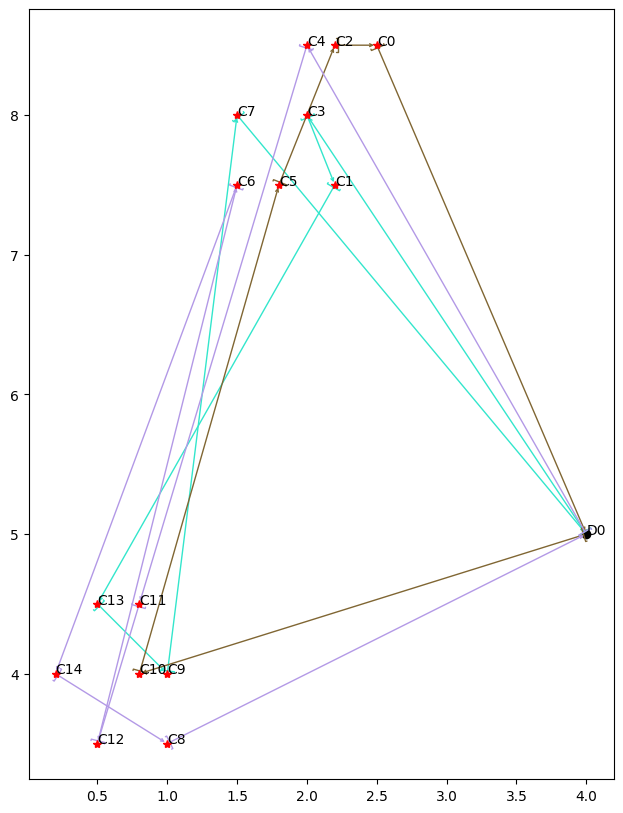

In [ ]:
Mvrp_plot(evaluation_data['clients'], evaluation_data['depots'], eval_r['routes'], 1, 3)

## 16

In [ ]:
## evaluation 1
## 16 customers
evaluation_data = create_data_ind(evaluation_df_1, depot_num)
evaluation_data = adding_depot_vehicles(evaluation_data, n_vehicles-1)

v_num = 3
test_mean_reward = []
eval_tour_indices = []

start_time = time.time()

eval_r, _ = evaluation_multi_vehicle(eval_sample, evaluation_df_1, networks, v_num, reward_fn_number)
eval_tour_indices = eval_r["routes"]
print("Dataset =>", dataset, dataset_num)
print("time taken for evaluation => seconds", (time.time()-start_time))

from scipy.spatial.distance import euclidean
depot_id = list(evaluation_data['depots'].keys())
print("depot_id",depot_id)

evaluation_distances = []
for key in eval_tour_indices.keys():
  dist = 0
  r = eval_tour_indices[key]
  for route in r:
    print(key,len(route), route)
    if len(route)<=1:
      continue
    for i in range(0, len(route)-1):
      if route[i] in evaluation_data['depots'].keys():
        # continue
        a = (evaluation_data['depots'][route[i]]['dep_x'], evaluation_data['depots'][route[i]]['dep_y'])
        b = (evaluation_data['clients'][route[i+1]].cx, evaluation_data['clients'][route[i+1]].cy)
      elif route[i+1] in evaluation_data['depots'].keys():
        # continue
        a = (evaluation_data['clients'][route[i]].cx, evaluation_data['clients'][route[i]].cy)
        b = (evaluation_data['depots'][route[i+1]]['dep_x'], evaluation_data['depots'][route[i+1]]['dep_y'])
      else:
        a = (evaluation_data['clients'][route[i]].cx, evaluation_data['clients'][route[i]].cy)
        b = (evaluation_data['clients'][route[i+1]].cx, evaluation_data['clients'][route[i+1]].cy)

      # print(route[i], route[i+1], a, b)
      euclidean_distance = euclidean(a,b)
      dist += euclidean_distance
  print(dist)
  evaluation_distances.append(dist)

print("results for vehicles =>", 3)
print(evaluation_distances)
print(f"Mean distance in evaluation 16 data {np.mean(evaluation_distances)}")
print(f"Sum distance in evaluation 16 data {np.sum(evaluation_distances)}")

print("Routes taken: ", eval_tour_indices)
print("\n================ evaluation 1 finished ======================\n")

Dataset => C 7
time taken for evaluation => seconds 0.010287761688232422
depot_id [15]
(0, 0) 4 [15, 10, 1, 15]
50.31228645359769
(0, 1) 5 [15, 13, 8, 0, 15]
87.25070108932009
(0, 2) 12 [15, 14, 12, 11, 4, 5, 3, 6, 7, 2, 9, 15]
118.73004231872986
results for vehicles => 3
[50.31228645359769, 87.25070108932009, 118.73004231872986]
Mean distance in evaluation 16 data 85.43100995388254
Sum distance in evaluation 16 data 256.2930298616476
Routes taken:  {(0, 0): [[15, 10, 1, 15]], (0, 1): [[15, 13, 8, 0, 15]], (0, 2): [[15, 14, 12, 11, 4, 5, 3, 6, 7, 2, 9, 15]]}

================ evaluation 1 finished ======================



## 25

In [ ]:
## evaluation 2
## 25 customers
evaluation_data = create_data_ind(evaluation_df_2, depot_num)
evaluation_data = adding_depot_vehicles(evaluation_data, n_vehicles-1)

v_num = vehicle_num[25]
# v_num = 3
test_mean_reward = []
eval_tour_indices = []

eval_r, _ = evaluation_multi_vehicle(eval_sample, evaluation_df_2, networks, v_num, reward_fn_number)
eval_tour_indices = eval_r["routes"]

from scipy.spatial.distance import euclidean
depot_id = list(evaluation_data['depots'].keys())
print("depot_id",depot_id)

evaluation_distances = []
for key in eval_tour_indices.keys():
  dist = 0
  r = eval_tour_indices[key]
  for route in r:
    print(key, route)
    if len(route)<=2:
      continue
    for i in range(0, len(route)-1):
      if route[i] in evaluation_data['depots'].keys():
        continue
        # a = (evaluation_data['depots'][route[i]]['dep_x'], evaluation_data['depots'][route[i]]['dep_y'])
        # b = (evaluation_data['clients'][route[i+1]].cx, evaluation_data['clients'][route[i+1]].cy)
      elif route[i+1] in evaluation_data['depots'].keys():
        continue
        # a = (evaluation_data['clients'][route[i]].cx, evaluation_data['clients'][route[i]].cy)
        # b = (evaluation_data['depots'][route[i+1]]['dep_x'], evaluation_data['depots'][route[i+1]]['dep_y'])
      else:
        a = (evaluation_data['clients'][route[i]].cx, evaluation_data['clients'][route[i]].cy)
        b = (evaluation_data['clients'][route[i+1]].cx, evaluation_data['clients'][route[i+1]].cy)

      # print(route[i], route[i+1], a, b)
      euclidean_distance = euclidean(a,b)
      dist += euclidean_distance
  print(dist)
  evaluation_distances.append(dist)

print("results for vehicles =>", vehicle_num[25])
print(evaluation_distances)
print(f"Mean distance in evaluation 25 data {np.mean(evaluation_distances)}")
print(f"Sum distance in evaluation 25 data {np.sum(evaluation_distances)}")
print("\n================ evaluation 2 finished ======================\n")

depot_id [24]
(0, 0) [24, 17, 22, 3, 21, 19, 14, 20, 24]
251.9693844094128
(0, 1) [24, 7, 18, 13, 4, 11, 2, 9, 0, 24]
346.82516219496796
(0, 2) [24, 10, 8, 15, 5, 1, 6, 23, 24]
131.18013730861168
(0, 3) [24, 12, 16, 24]
11.180339887498949
results for vehicles => 4
[251.9693844094128, 346.82516219496796, 131.18013730861168, 11.180339887498949]
Mean distance in evaluation 25 data 185.28875595012286
Sum distance in evaluation 25 data 741.1550238004914

================ evaluation 2 finished ======================



## 50

In [ ]:
## evaluation 2
## 50 customers
evaluation_data = create_data_ind(evaluation_df_3, depot_num)
evaluation_data = adding_depot_vehicles(evaluation_data, n_vehicles-1)

v_num = vehicle_num[50]
test_mean_reward = []
eval_tour_indices = []

eval_r, _ = evaluation_multi_vehicle(eval_sample, evaluation_df_3, networks, v_num, reward_fn_number)
eval_tour_indices = eval_r["routes"]

from scipy.spatial.distance import euclidean
depot_id = list(evaluation_data['depots'].keys())
print("depot_id",depot_id)

evaluation_distances = []
for key in eval_tour_indices.keys():
  dist = 0
  r = eval_tour_indices[key]
  print(key, r)
  for route in r:
    if len(route)<=2:
      continue
    for i in range(0, len(route)-1):
      if route[i] in evaluation_data['depots'].keys():
        continue
        # a = (evaluation_data['depots'][route[i]]['dep_x'], evaluation_data['depots'][route[i]]['dep_y'])
        # b = (evaluation_data['clients'][route[i+1]].cx, evaluation_data['clients'][route[i+1]].cy)
      elif route[i+1] in evaluation_data['depots'].keys():
        continue
        # a = (evaluation_data['clients'][route[i]].cx, evaluation_data['clients'][route[i]].cy)
        # b = (evaluation_data['depots'][route[i+1]]['dep_x'], evaluation_data['depots'][route[i+1]]['dep_y'])
      else:
        a = (evaluation_data['clients'][route[i]].cx, evaluation_data['clients'][route[i]].cy)
        b = (evaluation_data['clients'][route[i+1]].cx, evaluation_data['clients'][route[i+1]].cy)
      euclidean_distance = euclidean(a,b)
      dist += euclidean_distance
  print(dist)
  evaluation_distances.append(dist)

print("results for vehicles =>", vehicle_num[50])
print(evaluation_distances)
print(f"Mean distance in evaluation 50 data {np.mean(evaluation_distances)}")
print(f"Sum distance in evaluation 50 data {np.sum(evaluation_distances)}")

print("\n================ evaluation 3 finished ======================\n")

depot_id [49]
(0, 0) [[49, 29, 4, 43, 3, 18, 49]]
231.01973935413827
(0, 1) [[49, 5, 44, 0, 49]]
13.11106178412582
(0, 2) [[49, 17, 1, 39, 25, 27, 19, 12, 30, 49]]
358.122549006359
(0, 3) [[49, 36, 33, 48, 2, 37, 40, 8, 22, 31, 24, 49]]
438.47282694655206
(0, 4) [[49, 34, 6, 46, 7, 21, 49]]
192.62662541914807
(0, 5) [[49, 38, 16, 49]]
69.46221994724903
(0, 6) [[49, 28, 32, 26, 45, 14, 13, 10, 15, 20, 42, 23, 49]]
383.83044422198947
(0, 7) [[49, 35, 11, 41, 9, 47, 49]]
235.86669842962817
results for vehicles => 8
[231.01973935413827, 13.11106178412582, 358.122549006359, 438.47282694655206, 192.62662541914807, 69.46221994724903, 383.83044422198947, 235.86669842962817]
Mean distance in evaluation 50 data 240.31402063864874
Sum distance in evaluation 50 data 1922.51216510919

================ evaluation 3 finished ======================



## 100

In [ ]:
## evaluation 2
## 25 customers
evaluation_data = create_data_ind(evaluation_df_4, depot_num)
evaluation_data = adding_depot_vehicles(evaluation_data, n_vehicles-1)

v_num = vehicle_num[100]
test_mean_reward = []
eval_tour_indices = []

eval_r, _ = evaluation_multi_vehicle(eval_sample, evaluation_df_4, networks, v_num, reward_fn_number)
eval_tour_indices = eval_r["routes"]

from scipy.spatial.distance import euclidean
depot_id = list(evaluation_data['depots'].keys())
print("depot_id",depot_id)

evaluation_distances = []
for key in eval_tour_indices.keys():
  dist = 0
  r = eval_tour_indices[key]
  print(key, r)
  for route in r:
    if len(route)<=2:
      continue
    for i in range(0, len(route)-1):
      if route[i] in evaluation_data['depots'].keys():
        # continue
        a = (evaluation_data['depots'][route[i]]['dep_x'], evaluation_data['depots'][route[i]]['dep_y'])
        b = (evaluation_data['clients'][route[i+1]].cx, evaluation_data['clients'][route[i+1]].cy)
      elif route[i+1] in evaluation_data['depots'].keys():
        # continue
        a = (evaluation_data['clients'][route[i]].cx, evaluation_data['clients'][route[i]].cy)
        b = (evaluation_data['depots'][route[i+1]]['dep_x'], evaluation_data['depots'][route[i+1]]['dep_y'])
      else:
        a = (evaluation_data['clients'][route[i]].cx, evaluation_data['clients'][route[i]].cy)
        b = (evaluation_data['clients'][route[i+1]].cx, evaluation_data['clients'][route[i+1]].cy)
      euclidean_distance = euclidean(a,b)
      dist += euclidean_distance
  print(dist)
  evaluation_distances.append(dist)

print("results for vehicles =>", vehicle_num[100])
print(evaluation_distances)
print(f"Mean distance in evaluation 100 data {np.mean(evaluation_distances)}")
print(f"Sum distance in evaluation 50 data {np.sum(evaluation_distances)}")
print("\n================ evaluation 4 finished ======================\n")

depot_id [99, 100]
(0, 0) [[99, 51, 21, 7, 72, 70, 12, 55, 8, 89, 33, 95, 71, 99], [99, 99]]
506.7474538120946
(0, 1) [[99, 82, 79, 99]]
45.71911943164846
(0, 2) [[99, 69, 99]]
39.293765408777
(0, 3) [[99, 81, 49, 92, 99]]
101.81388242938472
(0, 4) [[99, 60, 76, 94, 6, 99]]
220.23739457318663
(0, 5) [[99, 91, 10, 88, 27, 1, 22, 34, 39, 99], [99, 78, 77, 99]]
534.4415086844313
(0, 6) [[99, 68, 75, 90, 99]]
102.6207069615686
(0, 7) [[99, 43, 67, 83, 87, 14, 97, 80, 84, 15, 99]]
364.4637998333689
(0, 8) [[99, 3, 13, 54, 26, 28, 50, 9, 2, 18, 99], [99, 63, 5, 99]]
535.8933468338779
(0, 9) [[99, 4, 0, 44, 23, 85, 25, 16, 99]]
350.48446680475104
(0, 10) [[99, 32, 29, 61, 17, 56, 31, 98, 24, 99]]
336.9003834838245
(0, 11) [[99, 38, 48, 47, 99]]
158.44195685313662
(0, 12) [[99, 30, 65, 37, 58, 53, 20, 74, 19, 64, 41, 42, 36, 99], [99, 99]]
541.8587121905019
(0, 13) [[99, 35, 11, 73, 45, 59, 99]]
247.56013354819572
(0, 14) [[99, 46, 52, 86, 62, 66, 96, 40, 93, 57, 99]]
433.35258163438164
result